<a href="https://colab.research.google.com/github/Nduati-R/-COVID-19-Global-Data-Tracker-/blob/main/COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Data loaded successfully from OWID

Dataset contains 429435 rows and 67 columns

✅ Cleaned data:
Time period: 2020-01-05 to 2024-08-12


<ipython-input-4-1cc403f7ea9b>:52: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



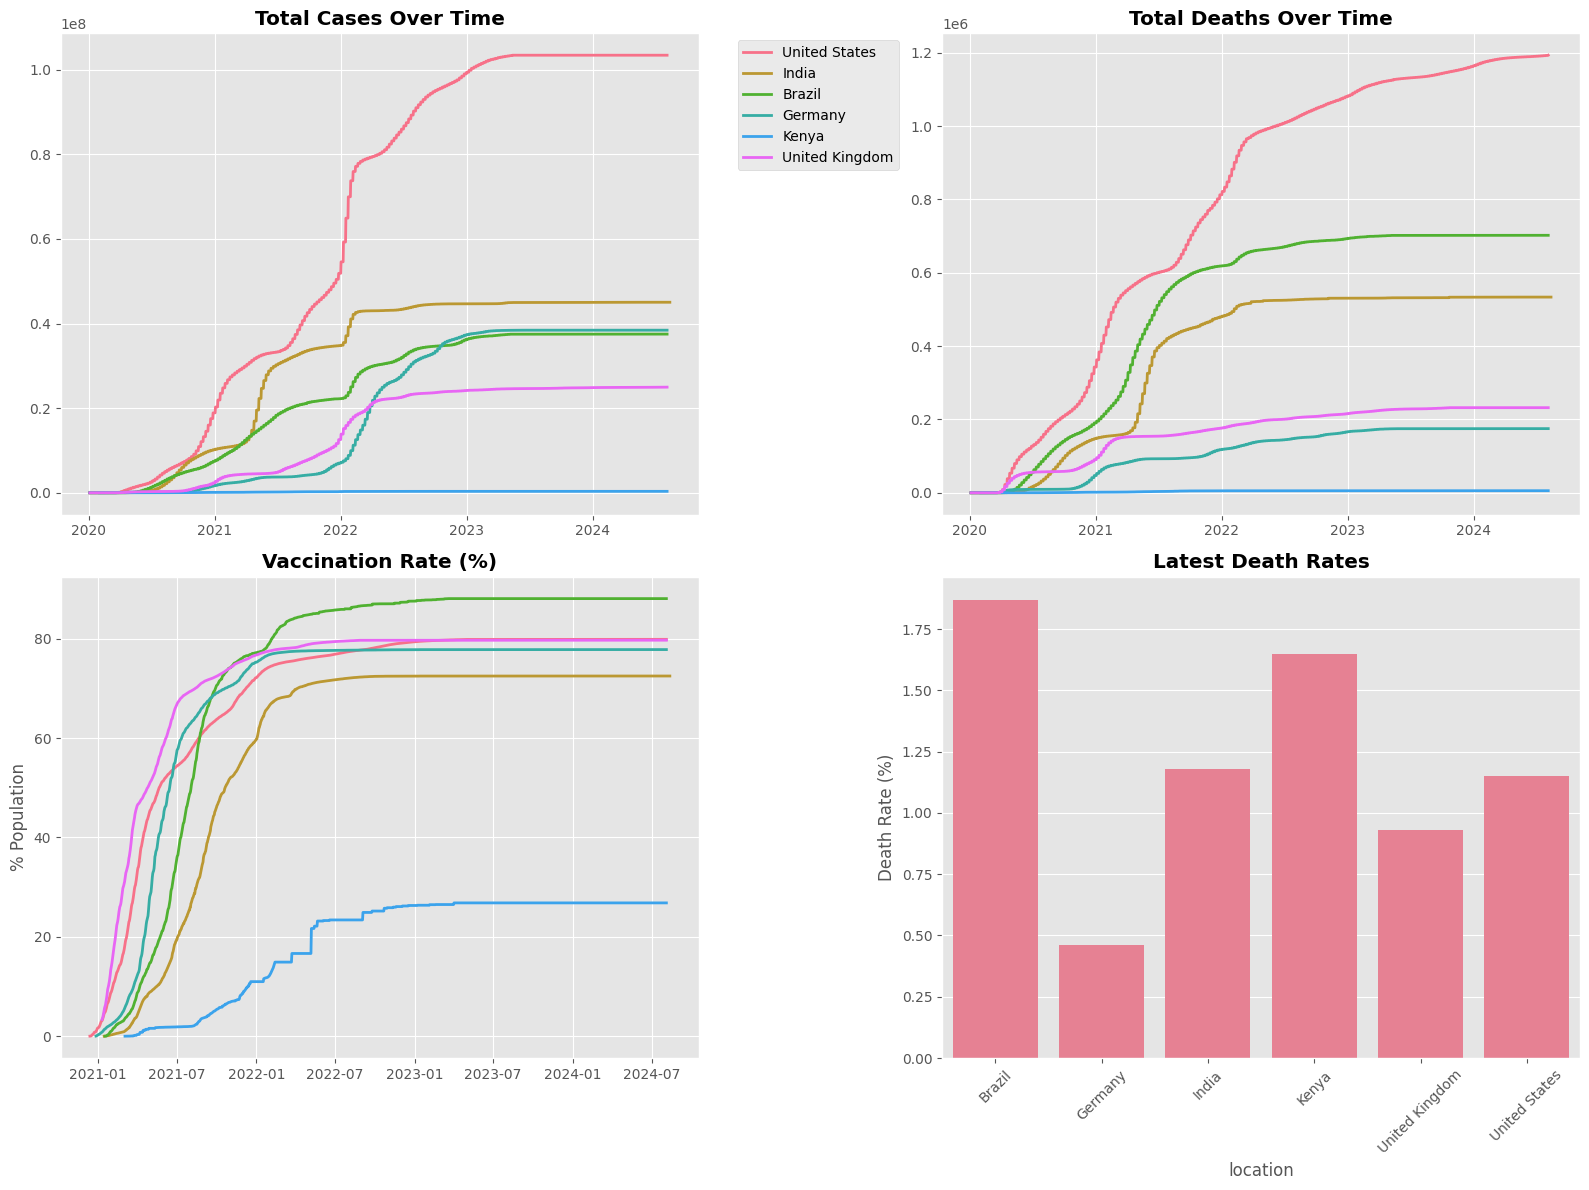

📊 COVID-19 ANALYSIS INSIGHTS

1. 🦠 Highest case count: United States (103,436,829 cases)
2. 💉 Vaccination leader: Brazil (88.1% vaccinated)
3. ☠️ Highest death rate: Brazil (1.87%)
4. 🌍 Average vaccination in selected countries: 70.8%

📅 Analysis period: 2020-01-05 to 2024-08-12


In [4]:
# %% [markdown]
# # COVID-19 Global Trends Analysis (Fixed Version)

# %% [markdown]
# ## 1. Setup and Data Loading

# %%
# Install required packages
!pip install plotly --quiet
!pip install --upgrade pandas --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

# Visualization settings
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

# Load data
data_url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
try:
    df = pd.read_csv(data_url)
    print("✅ Data loaded successfully from OWID")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    from google.colab import files
    uploaded = files.upload()
    df = pd.read_csv(next(iter(uploaded)))

# Initial exploration
print(f"\nDataset contains {len(df)} rows and {len(df.columns)} columns")
df.head()

# %% [markdown]
# ## 2. Data Cleaning (Fixed Index Issues)

# %%
# Convert date and filter data
df['date'] = pd.to_datetime(df['date'])
target_countries = ['United States', 'India', 'Brazil', 'Germany', 'Kenya', 'United Kingdom']
cols_to_keep = ['date', 'location', 'total_cases', 'new_cases', 'total_deaths',
               'new_deaths', 'people_vaccinated', 'population', 'icu_patients', 'iso_code']

df_clean = df[df['location'].isin(target_countries)][cols_to_keep].copy()

# Forward fill with proper index handling
df_clean = df_clean.groupby('location', group_keys=False).apply(lambda x: x.ffill())

# Calculate metrics
df_clean['death_rate'] = (df_clean['total_deaths'] / df_clean['total_cases'] * 100).round(2)
df_clean['cases_per_million'] = (df_clean['total_cases'] / df_clean['population'] * 1e6).round()
df_clean['vaccination_rate'] = (df_clean['people_vaccinated'] / df_clean['population'] * 100).round(2)

# Clean invalid values
df_clean = df_clean[(df_clean['death_rate'].between(0, 100) | df_clean['death_rate'].isna())]

print("\n✅ Cleaned data:")
print(f"Time period: {df_clean['date'].min().date()} to {df_clean['date'].max().date()}")
df_clean.tail()

# %% [markdown]
# ## 3. Interactive Visualizations

# %%
# Time series with Plotly
fig = px.line(df_clean,
              x='date',
              y='total_cases',
              color='location',
              title='<b>COVID-19 Cases by Country</b>',
              labels={'total_cases': 'Total Cases', 'date': 'Date'},
              hover_data=['total_deaths', 'vaccination_rate'],
              template='plotly_white')

fig.update_layout(
    hovermode='x unified',
    plot_bgcolor='white',
    title_x=0.5
)
fig.show()

# %% [markdown]
# ## 4. Comparative Analysis Dashboard

# %%
# Create matplotlib dashboard
plt.figure(figsize=(16, 12))

# 1. Cases subplot
plt.subplot(2, 2, 1)
for country in target_countries:
    subset = df_clean[df_clean['location'] == country]
    plt.plot(subset['date'], subset['total_cases'], label=country, linewidth=2)
plt.title('Total Cases Over Time', fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Deaths subplot
plt.subplot(2, 2, 2)
for country in target_countries:
    subset = df_clean[df_clean['location'] == country]
    plt.plot(subset['date'], subset['total_deaths'], linewidth=2)
plt.title('Total Deaths Over Time', fontweight='bold')

# 3. Vaccination subplot
plt.subplot(2, 2, 3)
for country in target_countries:
    subset = df_clean[df_clean['location'] == country].dropna(subset=['vaccination_rate'])
    plt.plot(subset['date'], subset['vaccination_rate'], linewidth=2)
plt.title('Vaccination Rate (%)', fontweight='bold')
plt.ylabel('% Population')

# 4. Death rate subplot
plt.subplot(2, 2, 4)
latest_data = df_clean.sort_values('date').groupby('location', as_index=False).last()
sns.barplot(data=latest_data, x='location', y='death_rate')
plt.title('Latest Death Rates', fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('Death Rate (%)')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 5. Global Map Visualization

# %%
# World map with proper data handling
try:
    world_latest = df.sort_values('date').groupby('location', as_index=False).last()

    fig = px.choropleth(world_latest,
                        locations='iso_code',
                        color='total_cases_per_million',
                        hover_name='location',
                        color_continuous_scale='Viridis',
                        title='<b>Global COVID-19 Cases per Million</b>',
                        projection='natural earth')

    fig.update_layout(
        margin={"r":0,"t":40,"l":0,"b":0},
        title_x=0.5
    )
    fig.show()
except Exception as e:
    print(f"⚠️ Map visualization error: {str(e)}")

# %% [markdown]
# ## 6. Automated Insights Generation

# %%
# Generate and display insights
latest_stats = df_clean.sort_values('date').groupby('location', as_index=False).last()

print("📊 COVID-19 ANALYSIS INSIGHTS\n")
print(f"1. 🦠 Highest case count: {latest_stats.loc[latest_stats['total_cases'].idxmax(), 'location']} "
      f"({latest_stats['total_cases'].max():,.0f} cases)")
print(f"2. 💉 Vaccination leader: {latest_stats.loc[latest_stats['vaccination_rate'].idxmax(), 'location']} "
      f"({latest_stats['vaccination_rate'].max():.1f}% vaccinated)")
print(f"3. ☠️ Highest death rate: {latest_stats.loc[latest_stats['death_rate'].idxmax(), 'location']} "
      f"({latest_stats['death_rate'].max():.2f}%)")
print(f"4. 🌍 Average vaccination in selected countries: {latest_stats['vaccination_rate'].mean():.1f}%")
print(f"\n📅 Analysis period: {df_clean['date'].min().date()} to {df_clean['date'].max().date()}")